# Quick first Model for multivariable regression


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

print(tf.__version__)

2.4.0


Load the dataset

In [34]:
src_path = r"/Users/astromeria/PycharmProjects/SPWLA_2021_Geolatinas/dataset/separated_wells/train/" #local folder
col_names_x = ["NEU", "GR", "DEN", "RDEP"]
col_names_y = ["VSH", "PHIF", "SW"]
col_names_all = col_names_x + col_names_y
wells_list = []
for i in range(1,9): #load all the well log files but well0
    well_data = pd.read_csv(src_path+"well_"+str(i)+".csv")
    well_data= well_data[col_names_all]
    wells_list.append(well_data)
well_all = pd.concat(wells_list)#merge in a single dataframe


well_all= well_all.dropna() #delete all the rows that contain at least one empty value

#function to normalice the data
def norm(x, train_stats):
  return (x - train_stats['mean']) / train_stats['std']



#obtain stats from training data for normalization
train_dataset = well_all.sample(frac=0.8,random_state=0)
test_dataset = well_all.drop(train_dataset.index)


#separate in x (inputs) and y(targets or outputs)
x_train = train_dataset[col_names_x]
y_train = train_dataset[col_names_y]

x_test = test_dataset[col_names_x]
y_test = test_dataset[col_names_y]
x_train["RDEP"] = np.log10(x_train['RDEP'].abs())
x_test["RDEP"] = np.log10(x_test['RDEP'].abs())

train_stats = x_train.describe()
train_stats = train_stats.transpose()
print(train_stats)

x_train = norm(x_train, train_stats)
x_test = norm(x_test, train_stats)


print(x_train)

        count       mean        std       min        25%        50%  \
NEU   32154.0   0.181087   0.066216 -0.003400   0.143378   0.176100   
GR    32154.0  39.210315  24.157337  4.588597  19.432875  34.971300   
DEN   32154.0   2.410082   0.162798  1.626600   2.260900   2.416100   
RDEP  32154.0   0.624842   0.642056 -0.887730   0.200242   0.479222   

            75%         max  
NEU    0.215400    0.579414  
GR    51.210250  129.343000  
DEN    2.546700    3.089600  
RDEP   0.976309    4.904536  
            NEU        GR       DEN      RDEP
44026 -0.315439 -1.217386 -1.090816 -0.027966
32301 -0.280704  0.758489  0.793119 -0.883552
18142  1.615148  0.608216  0.073206 -0.240794
35411 -0.362255 -1.122231 -1.606179  2.281021
37844 -0.351684 -0.833582 -0.490070  0.634627
...         ...       ...       ...       ...
39313 -0.110051 -0.889590 -0.771401  0.852853
32876  0.060603 -0.933767 -1.305192  1.465680
36365  2.380279  0.512047  2.089206 -0.381943
40154  0.256929 -0.567129 -1.68296

/var/folders/8y/hj33fmqn6p91_stmd8t5z7cw0000gn/T/ipykernel_4867/1980945827.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train["RDEP"] = np.log10(x_train['RDEP'].abs())
/var/folders/8y/hj33fmqn6p91_stmd8t5z7cw0000gn/T/ipykernel_4867/1980945827.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test["RDEP"] = np.log10(x_test['RDEP'].abs())


In [35]:
#function that returns the model architecture
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(y_train.keys()))
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse',])
  return model

In [36]:
#training history plotting function
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.02])
  plt.legend()
  plt.show()

Epoch 1/100
905/905 - 1s - loss: 0.0041 - mae: 0.0363 - mse: 0.0041 - val_loss: 0.0021 - val_mae: 0.0291 - val_mse: 0.0021
Epoch 2/100
905/905 - 0s - loss: 0.0018 - mae: 0.0250 - mse: 0.0018 - val_loss: 0.0028 - val_mae: 0.0320 - val_mse: 0.0028
Epoch 3/100
905/905 - 0s - loss: 0.0016 - mae: 0.0226 - mse: 0.0016 - val_loss: 0.0016 - val_mae: 0.0224 - val_mse: 0.0016
Epoch 4/100
905/905 - 0s - loss: 0.0015 - mae: 0.0213 - mse: 0.0015 - val_loss: 0.0017 - val_mae: 0.0243 - val_mse: 0.0017
Epoch 5/100
905/905 - 0s - loss: 0.0014 - mae: 0.0205 - mse: 0.0014 - val_loss: 0.0012 - val_mae: 0.0180 - val_mse: 0.0012
Epoch 6/100
905/905 - 0s - loss: 0.0013 - mae: 0.0198 - mse: 0.0013 - val_loss: 0.0012 - val_mae: 0.0177 - val_mse: 0.0012
Epoch 7/100
905/905 - 0s - loss: 0.0013 - mae: 0.0192 - mse: 0.0013 - val_loss: 0.0015 - val_mae: 0.0227 - val_mse: 0.0015
Epoch 8/100
905/905 - 0s - loss: 0.0013 - mae: 0.0188 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0199 - val_mse: 0.0013
Epoch 9/100
905/

905/905 - 0s - loss: 9.0931e-04 - mae: 0.0153 - mse: 9.0931e-04 - val_loss: 0.0011 - val_mae: 0.0175 - val_mse: 0.0011
Epoch 66/100
905/905 - 0s - loss: 9.0822e-04 - mae: 0.0153 - mse: 9.0822e-04 - val_loss: 0.0010 - val_mae: 0.0168 - val_mse: 0.0010
Epoch 67/100
905/905 - 0s - loss: 9.0543e-04 - mae: 0.0153 - mse: 9.0543e-04 - val_loss: 9.7395e-04 - val_mae: 0.0153 - val_mse: 9.7395e-04
Epoch 68/100
905/905 - 0s - loss: 9.1014e-04 - mae: 0.0153 - mse: 9.1014e-04 - val_loss: 0.0011 - val_mae: 0.0187 - val_mse: 0.0011
Epoch 69/100
905/905 - 0s - loss: 9.1121e-04 - mae: 0.0153 - mse: 9.1121e-04 - val_loss: 0.0013 - val_mae: 0.0205 - val_mse: 0.0013
Epoch 70/100
905/905 - 0s - loss: 9.0417e-04 - mae: 0.0153 - mse: 9.0417e-04 - val_loss: 0.0011 - val_mae: 0.0168 - val_mse: 0.0011
Epoch 71/100
905/905 - 0s - loss: 9.1053e-04 - mae: 0.0153 - mse: 9.1053e-04 - val_loss: 0.0011 - val_mae: 0.0174 - val_mse: 0.0011
Epoch 72/100
905/905 - 0s - loss: 8.9793e-04 - mae: 0.0152 - mse: 8.9793e-04 - va

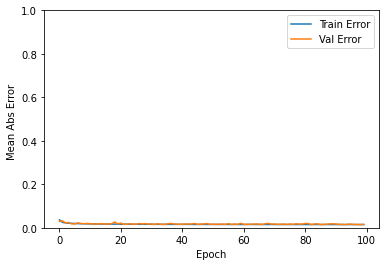

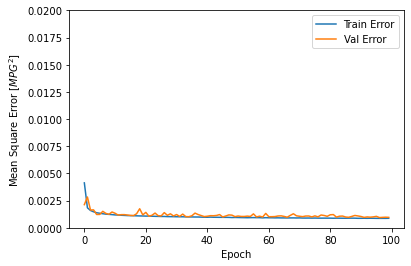

In [37]:
checkpoint = keras.callbacks.ModelCheckpoint( "/Users/astromeria/Documents/SPWLA_competition/weights/vshale_norm/all_outputs.h5", save_best_only=True, monitor = "val_loss")

#create a model instance
model = build_model()
EPOCHS = 100 #number of iterations for training

history = model.fit(
  x_train, y_train,
  epochs=EPOCHS, validation_split = 0.1, verbose=2, #just 10% for validation to use most of the data on training
  callbacks=[checkpoint])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
plot_history(history)

93/93 - 0s - loss: 0.0011 - mae: 0.0151 - mse: 0.0011
Testing set Mean Abs Error:  0.02 
(2969, 3)


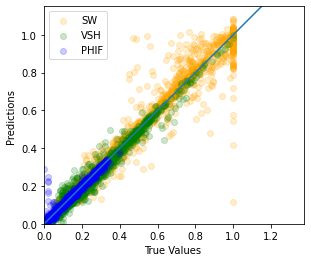

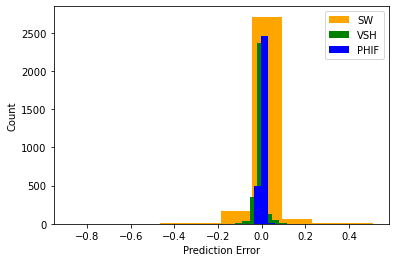

In [38]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))


test_predictions = model.predict(x_test)
predictions_file= os.path.join(os.getcwd(), "predictions_vhs_well0.npy")
np.save(predictions_file, test_predictions)
print(test_predictions.shape)
plt.scatter(y_test["SW"], test_predictions[:,2], color = "orange", label = col_names_y[2],alpha=0.2)
plt.scatter(y_test["VSH"], test_predictions[:,0], color = "green", label = col_names_y[0], alpha=0.2)
plt.scatter(y_test["PHIF"], test_predictions[:,1], color = "blue", label = col_names_y[1], alpha=0.2)

           
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.legend()
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


error = test_predictions - np.asarray(y_test)
plt.hist(error[:,2] , color="orange", label = col_names_y[2])
plt.hist(error[:,0], color = "green", label = col_names_y[0])
plt.hist(error[:,1],  color="blue", label = col_names_y[1])

plt.legend()
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")